In [29]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

## Step 1: preprocess data

In [30]:
def load_data(directory):
    
    # load data as a normalized way
    
    C=10  #number of classes
    X = LoadBatch(directory)[b'data'].transpose()
    # normalize the raw input data
    X_mean = X.mean(axis=1).reshape(-1,1)
    X_std = X.std(axis=1).reshape(-1,1)
    X = (X-X_mean)/X_std
    y = np.array(LoadBatch(directory)[b'labels'])
    #one-hot representation of the label for each image
    Y = np.eye(C, dtype=int)[y].transpose()
    return X, Y, y

def LoadBatch(filename):
    """ Copied from the dataset website """
    with open(filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [31]:
Xtr, Ytr, ytr = load_data("/Users/imogen/Desktop/Assignment1/cifar-10-batches-py/data_batch_1")
Xva, Yva, yva = load_data("/Users/imogen/Desktop/Assignment1/cifar-10-batches-py/data_batch_2")
Xte, Yte, yte = load_data("/Users/imogen/Desktop/Assignment1/cifar-10-batches-py/test_batch")

## Step2: define some functions in model

In [51]:
def ComputeGradsNumSlow( X, Y, P, W, b, h,lamda):
        
        # centered difference formula 
        
        k = W.shape[0]
        d = X.shape[0]

        grad_W = np.zeros(W.shape)
        grad_b = np.zeros((k, 1))   

        for i in range(len(b)):
            b_try = np.array(b)
            b_try[i] -= h
            c1 = compute_cost(X, Y, W, b_try,lamda)

            b_try = np.array(b)
            b_try[i] += h
            c2 = compute_cost(X, Y, W, b_try,lamda)

            grad_b[i] = (c2-c1) / (2*h)

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W_try = np.array(W)
                W_try[i,j] -= h
                c1 = compute_cost(X, Y, W_try, b,lamda)

                W_try = np.array(W)
                W_try[i,j] += h
                c2 = compute_cost(X, Y, W_try, b, lamda)

                grad_W[i,j] = (c2-c1) / (2*h)

        return [grad_W, grad_b]
    
def load_label_names(self):
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        

def ini_parameters(X, Y):
    
    #generate w and b according to the shape of inputs   
    std=np.sqrt(2/X.shape[0]) 
    #std=0.01
    np.random.seed(100)
    W = std*np.random.randn(Y.shape[0],X.shape[0])+0
    np.random.seed(100)
    b = std*np.random.randn(Y.shape[0],1)+0
    return W, b
    
    
def evaluate_classifier(X, W, b):
        
    # Write a function that evaluates the network function                                            
    
        assert(X.shape[0]== W.shape[1])
        s=np.dot(W, X)+b
        return  softmax(s)
    
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)    


def compute_cost(X, Y, y, W, b, lamda,svm=False):
        
    # calculate full loss function
    if svm ==False:
        L = cross_entropy(X, Y, W, b)+np.sum(W**2)*lamda
    elif svm==True:
        L = svm_loss(X, y, W, b)+np.sum(W**2)*lamda
    return L
        
    
def cross_entropy(X, Y, W, b):
        
      #define cross entropy loss
    
    cross_entropy_loss = np.dot(Y.transpose(), evaluate_classifier(X,W,b))               
    cross_entropy_loss = np.diag(cross_entropy_loss)
    cross_entropy_loss = -np.log(cross_entropy_loss)
    loss = np.sum(cross_entropy_loss)/ Y.shape[1]
    return loss

def svm_loss(X, y, W, b):
    
    #define svm loss
    
    assert(X.shape[0]== W.shape[1])
    s=np.dot(W, X)+b
    l=np.zeros(s.shape)
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            l[i][j]= max(0, s[i][j]-s[y[j]][j]+1)
    loss=np.sum(l)/ X.shape[1]
    return loss   
   
    
def compute_accuracy(X, y, W, b):
        
  #compute the accuracy of the network prediction

    k = np.argmax(evaluate_classifier(X,W,b), axis=0)
    acc=0
    for i in range(X.shape[1]):
        if k[i]==y[i]:
            acc+=1
    acc=acc/X.shape[1]
    return acc
        
    
def compute_gradient(X, Y, W, b,lamda,svm=False):
         
    #evaluate the gradients of the cost function for a mini-batch
    if svm==False:
        P=evaluate_classifier(X, W, b)
    
        g=P-Y
        assert(X.shape[1]== g.shape[1])
        grad_b = np.dot(g,np.ones((X.shape[1],1)))/X.shape[1]
        grad_w = np.dot(g, X.T)/X.shape[1]+2*lamda*W
        return grad_w, grad_b
    else:
        n = X.shape[1]
        d = X.shape[0]
        K = Y.shape[0]
        gradW = np.zeros((K, d))
        gradb = np.zeros((K, 1))

        for i in range(n):
            x = X[:, i]
            y_int = np.where(Y[:, [i]].T[0] == 1)[0][0]
            s = np.dot(W, X[:, [i]]) + b
            for j in range(K):
                if j != y_int:
                    if max(0, s[j] - s[y_int] + 1) != 0:
                        gradW[j] += x
                        gradW[y_int] += -x
                        gradb[j, 0] += 1
                        gradb[y_int, 0] += -1

        gradW /= n
        gradW += lamda * W
        gradb /= n
        return gradW, gradb


def ComputeGradsNum(X, Y, y, W, b, h, lamda):
        
    # finite difference method
    
        k = W.shape[0]
        d = X.shape[0]

        grad_W = np.zeros(W.shape);
        grad_b = np.zeros((k, 1));

        c = compute_cost(X, Y, y, W, b,lamda,svm=False);
        
        
        for i in range(b.shape[0]):
            
            b_try1 = np.array(b)
            b_try2 = np.array(b)
            b_try1[i][0] += h
            b_try2[i][0] -= h
        
            
            c1 = compute_cost(X, Y,y, W, b_try1,lamda,svm=False)
            c2 = compute_cost(X, Y, y,W, b_try2,lamda,svm=False)
            grad_b[i] = (c1-c2) / (2*h)
            
            
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W_try = np.array(W)
                W_try[i,j] += h
                c2 = compute_cost(X, Y,y, W_try, b,lamda,svm=False)
                grad_W[i,j] = (c2-c) / h

        return [grad_W, grad_b]
    
def montage(W):
	""" Display the image for each label in W """
	import matplotlib.pyplot as plt
	fig, ax = plt.subplots(2,5)
	for i in range(2):
		for j in range(5):
			im  = W[5*i+j,:].reshape(32,32,3, order='F')
			sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
			sim = sim.transpose(1,0,2)
			ax[i][j].imshow(sim, interpolation='nearest')
			ax[i][j].set_title("y="+str(5*i+j))
			ax[i][j].axis('off')
	plt.show()

In [33]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    #remember to transpose inputs when using this
    #assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        return inputs[excerpt], targets[excerpt]

## Step3:check gradients 

In [34]:
xmini, ymini=iterate_minibatches(Xtr.T, ytr, 10)
xmini=xmini.T
Ymini = np.eye(10, dtype=int)[ymini].transpose()
W, b= ini_parameters(xmini, Ymini)
P=evaluate_classifier(xmini, W, b)
gnw, gnb=ComputeGradsNum(X=xmini, Y= Ymini,y=ymini,  W=W, b=b, h=0.0001,lamda=0)
gaw, gab=compute_gradient(X=xmini, Y= Ymini,  W=W,b=b,lamda=0,svm=False)
err=np.abs(gaw-gnw)/(np.abs(gaw)+np.abs(gnw))
print(err)

[[4.87425118e-05 7.22898049e-05 7.27045314e-05 ... 2.84267208e-05
  2.56715739e-05 2.29838789e-05]
 [1.64718644e-05 1.47451587e-05 1.31801765e-05 ... 1.96860348e-05
  2.13044802e-05 1.89527243e-05]
 [4.65312211e-05 7.54251908e-05 5.55384394e-04 ... 3.24474729e-05
  3.14185880e-05 4.30264443e-05]
 ...
 [1.28579152e-05 1.46799183e-05 1.47388801e-05 ... 1.10310161e-04
  6.92309810e-05 1.04336794e-04]
 [8.28946214e-05 4.58454207e-05 5.06499686e-05 ... 1.96433390e-05
  1.74826565e-05 1.52020026e-05]
 [9.24592021e-06 1.04256047e-05 1.25447664e-05 ... 3.44973823e-05
  2.65834069e-05 2.36534415e-05]]


## Step4:build a one layer classifier

In [52]:
class one_layer_classifier():
    
    def __init__(self, lamda=0, n_epochs=40, n_batch=100, eta=0.1, decay_factor=1,svm=False):
    
        self.W, self.b = ini_parameters(Xtr, Ytr)
        self.P = 0
        self.lamda=lamda
        self.n_batch=n_batch
        self.n_epochs=n_epochs
        self.eta = eta
        self.decay_factor=decay_factor
        self.svm=svm
        self.best_b=0
        self.best_w=0
    
    def fit(self,Xtr, Ytr, ytr, Xva, Yva, yva):
        
        trainingloss=[]
        validationloss=[]
        trainingaccuracy=[]
        validationaccuracy=[]
        
        for i in range(self.n_epochs):
            best_model=0
            best_acc=0
            l1=compute_cost(Xtr, Ytr, ytr, self.W, self.b, self.lamda,self.svm)
            trainingloss.append(l1)
            acc=compute_accuracy(Xtr, ytr, self.W, self.b)
            trainingaccuracy.append(acc)
            print("the",format(i),"epoch for training data,"," the loss is", l1, "the accuracy is ",acc)
            l2=compute_cost(Xva, Yva, yva, self.W, self.b, self.lamda,self.svm)
            validationloss.append(l2)
            acc=compute_accuracy(Xva, yva, self.W, self.b)
            if acc>best_acc:
                best_model=i
                best_acc=acc
                self.best_w=self.W
                self.best_b=self.b
            validationaccuracy.append(acc)
            print("the",format(i),"epoch for validation data,"," the loss is", l2, "the accuracy is ",acc)
            
            Xtr, ytr=iterate_minibatches(Xtr.T, ytr, 10000, shuffle=True)
            Xtr=Xtr.T
            Ytr = np.eye(10, dtype=int)[ytr].transpose()
           # print(Xtr.shape,Ytr.shape,ytr.shape)
            
            for i in range(Xtr.shape[1]//self.n_batch):
                
                x_mini_batch = Xtr.T[i*self.n_batch:(i+1)*self.n_batch]
                Y_mini_batch = Ytr.T[i*self.n_batch:(i+1)*self.n_batch]
                
                
                
                gradw, gradb = compute_gradient(x_mini_batch.T, Y_mini_batch.T, self.W, self.b, self.lamda,self.svm)
                self.W-= gradw*self.eta
                self.b-= gradb*self.eta
                
            self.eta = self.eta * self.decay_factor
            
        x = range(1,self.n_epochs+1)    
        plt.plot(x, trainingloss,  label = "training loss" )
        plt.plot(x, validationloss, label = "validation loss" )
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.title('training and validation loss') 
        plt.show()
        
        x = range(1,self.n_epochs+1)    
        plt.plot(x, trainingaccuracy,  label = "training accuracy" )
        plt.plot(x, validationaccuracy, label = "validation accuracy" )
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.legend()
        plt.title('training and validation accuracy') 
        plt.show()
        
        #print(self.W,self.b)
        montage(self.W)  
        print("the best model is in",best_model, "the accuracy is",best_acc)
        
    def predict(self, Xte, Yte, yte):
        
        l=compute_cost(Xte, Yte,yte, self.best_w, self.best_b, self.lamda,self.svm)
        acc=compute_accuracy(Xte, yte, self.best_w, self.best_b)
        print("the loss is", l, "the accuracy is ",acc)
        

the 0 epoch for training data,  the loss is 12.751186458565249 the accuracy is  0.105
the 0 epoch for validation data,  the loss is 12.715013264832637 the accuracy is  0.1189
the 1 epoch for training data,  the loss is 6.473181393223642 the accuracy is  0.3038
the 1 epoch for validation data,  the loss is 6.949076036833501 the accuracy is  0.2851
the 2 epoch for training data,  the loss is 5.882632928279813 the accuracy is  0.3384
the 2 epoch for validation data,  the loss is 6.532380735780628 the accuracy is  0.313
the 3 epoch for training data,  the loss is 5.562038536493481 the accuracy is  0.3635
the 3 epoch for validation data,  the loss is 6.342612748754325 the accuracy is  0.3273
the 4 epoch for training data,  the loss is 5.427130345966734 the accuracy is  0.3717
the 4 epoch for validation data,  the loss is 6.266670615782646 the accuracy is  0.3305
the 5 epoch for training data,  the loss is 5.292425215898371 the accuracy is  0.3907
the 5 epoch for validation data,  the loss i

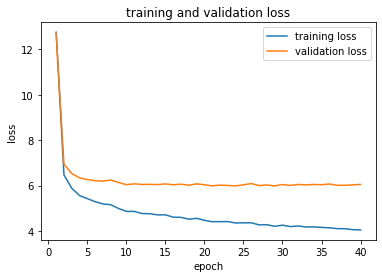

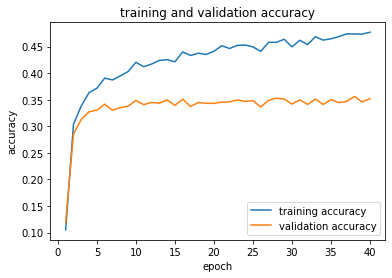

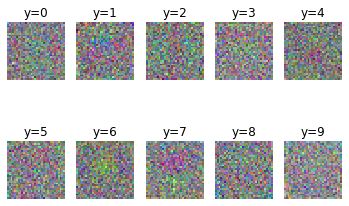

the best model is in 39 the accuracy is 0.3522
the loss is 6.014878148630898 the accuracy is  0.349


In [57]:
c = one_layer_classifier(lamda=0, n_epochs=40, n_batch=100, eta=0.001, decay_factor=1,svm=True)
c.fit(Xtr, Ytr,ytr, Xva, Yva, yva)
c.predict(Xte, Yte, yte)

the 0 epoch for training data,  the loss is 14.751546849957414 the accuracy is  0.105
the 0 epoch for validation data,  the loss is 14.715373656224802 the accuracy is  0.1189
the 1 epoch for training data,  the loss is 8.393188073591466 the accuracy is  0.3047
the 1 epoch for validation data,  the loss is 8.868094271329475 the accuracy is  0.2847
the 2 epoch for training data,  the loss is 7.749358099070735 the accuracy is  0.3384
the 2 epoch for validation data,  the loss is 8.396817147801212 the accuracy is  0.3132
the 3 epoch for training data,  the loss is 7.373446086656347 the accuracy is  0.3653
the 3 epoch for validation data,  the loss is 8.147584454758606 the accuracy is  0.3289
the 4 epoch for training data,  the loss is 7.196792360779071 the accuracy is  0.3742
the 4 epoch for validation data,  the loss is 8.026408862846626 the accuracy is  0.3313
the 5 epoch for training data,  the loss is 7.0211961384542345 the accuracy is  0.3908
the 5 epoch for validation data,  the loss

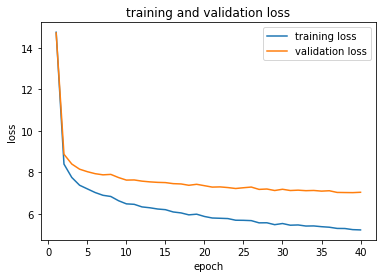

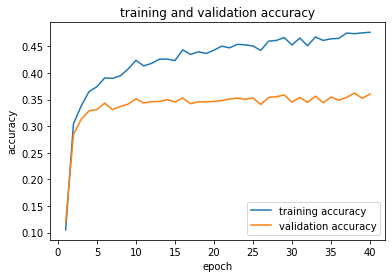

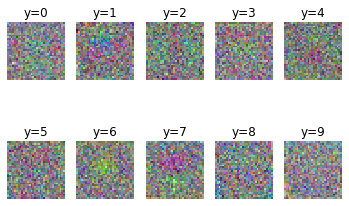

the best model is in 39 the accuracy is 0.3604
the loss is 7.008057398981481 the accuracy is  0.3519


In [58]:
c = one_layer_classifier(lamda=0.1, n_epochs=40, n_batch=100, eta=0.001, decay_factor=1,svm=True)
c.fit(Xtr, Ytr,ytr, Xva, Yva, yva)
c.predict(Xte, Yte, yte)

the 0 epoch for training data,  the loss is 32.75479037248691 the accuracy is  0.105
the 0 epoch for validation data,  the loss is 32.7186171787543 the accuracy is  0.1189
the 1 epoch for training data,  the loss is 22.546086894079863 the accuracy is  0.3075
the 1 epoch for validation data,  the loss is 23.002793463997094 the accuracy is  0.2863
the 2 epoch for training data,  the loss is 18.922268172315462 the accuracy is  0.3439
the 2 epoch for validation data,  the loss is 19.535904867193494 the accuracy is  0.3182
the 3 epoch for training data,  the loss is 16.163775915904267 the accuracy is  0.3764
the 3 epoch for validation data,  the loss is 16.88149194887008 the accuracy is  0.3388
the 4 epoch for training data,  the loss is 14.1401295547493 the accuracy is  0.3835
the 4 epoch for validation data,  the loss is 14.89257412304161 the accuracy is  0.3391
the 5 epoch for training data,  the loss is 12.488644954822544 the accuracy is  0.4017
the 5 epoch for validation data,  the los

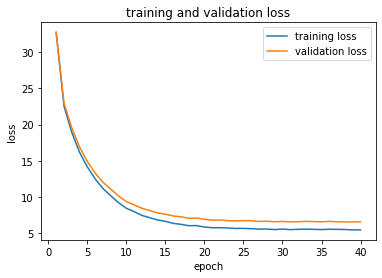

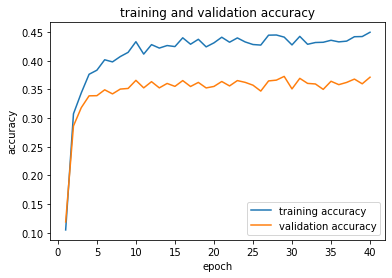

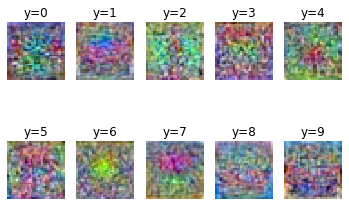

the best model is in 39 the accuracy is 0.3713
the loss is 6.546917857521548 the accuracy is  0.3548


In [59]:
c = one_layer_classifier(lamda=1, n_epochs=40, n_batch=100, eta=0.001, decay_factor=1,svm=True)
c.fit(Xtr, Ytr,ytr, Xva, Yva, yva)
c.predict(Xte, Yte, yte)